# Computational Essays on Artificial Intelligence
## Evolving _Novel_ Robot Controller for Coverage

In this essay, we explore using Novelty Search to measure the fitness for a Genetic Algorithm that is evolving neural networks for robot control.


For this demonstration, we will need:

* `GeneticAlgorithm` and `NoveltySearch` defined in aitk.algorithms
* `World`, `Scribbler`, `RangeSensor` from aitk.robots 
* `SimpleNetwork` from aitk.networks
* a few other support functions

We import everything need in this cell:

In [1]:
from aitk.algorithms import GeneticAlgorithm, NoveltySearch
from aitk.robots import World, Scribbler, RangeSensor
from aitk.networks import SimpleNetwork
from aitk.robots.utils import distance
from aitk.utils import gallery, Grid, Color
import random
import math

## Novelty Search

Rather than searching for a particular objective, the goal of novelty search is to discover unique behaviors. It accomplishes this by maintaining an archive of behaviors.  The archive has a limited size, and only novel behaviors are stored in the archive. A behavior must have a novelty score above a given threshold to qualify. 

We are interested in developing robot behaviors to move about in a small environment without getting stuck and visiting as much of the environment as possible. 

We will impose a grid on top of the environment and we will define a behavior as the sequence of newly visited grid locations. Our grid will be 10x10 so the maximum possible length of a behavior sequence is 100.  The robot will always start in the center and be allowed to move around for 60 seconds. Some behavior sequences might be quite short, for instance if the robot simply spins in the center only visiting a few cells.  We will pad all behavior sequences with (0,0) points to make them the same maximum length.

Then to calculate novelty we will look at the distance between the k nearest neighbor behavior sequences in the archive. If the average distance from these k nearest neighbors is high enough, then the behavior is considered novel.

The following function is used to determine a quick upper bound on the maximum possible distance between two behavior sequences. It simply computes the maximum distance between two locations in the grid, and multiplies that times the number of maximum possible number of moves.

In our example, with a 10x10 grid, the minimum point is (0,0), the maximum point is (9,9), and the number of points is 100.

In [2]:
def get_max_distance(grid_size):
    """Get the maximum possible distance between two behaivors"""
    min_pt = (0, 0)
    max_pt = (grid_size - 1, grid_size - 1)
    num_pts = grid_size * grid_size 
    return distance(min_pt, max_pt) * num_pts

In [3]:
get_max_distance(10)

1272.7922061357856

When initializing novelty search one must determine **k**, the archive size **limit**, the novelty **threshold**, and the **maximum distance** between behaviors. We will use k=15, limit=100, threshold=0.2, and distance determined by the above function.

## The Genetic Algorithm

The [Genetic Algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm) (GA) is an approach inside the category of machine learning systems called [Evolutionary Algorithms](https://en.wikipedia.org/wiki/Evolutionary_algorithm) (EA). For this essay, we will use the GA as follows:

1. We will define a `gene` to be a floating-point number that represents the weight or bias of a Neural Network.
2. We will define a `chromosome` as a sequence of genes. The chromosome (sometimes called a `geneotype`) will represent all of the weights and biases of a network.
3. A`population` will be composed of a set of random chromosomes.

The length of the chromosome is determined by the size of the Neural Network. Therefore, we will call `self.build_model()` (defined below) and see how many weights it has. 

We'll use a ring of 16 laser sensors as senses. We create a small simulated world (200 x 200) to allow the robot to move around.

The basic idea is that we will have a list of weights (the chromosome) that we load into the neural network. The sensors will be read, and propagated through the neural network. The output of the neural network will be interpreted as movement controls. We'll let the neural network "drive" the robot around the world starting from the center of the world.  

In [4]:
class NoveltyGA(GeneticAlgorithm):
    """
    An example of using the GeneticAlgorithm class to 
    evolve the weights of a neural network to control 
    a simulated robot using Novelty Search to determine
    the fitness.
    """
    def __init__(self, popsize, sensors=16, grid_size=10):
        self.novelty_search = NoveltySearch(
            k=15, 
            limit=100, 
            threshold=0.2,
            max_dist=get_max_distance(grid_size),
        )
        self.show = False
        self.sensors = sensors
        self.world = World(200, 200)
        self.robot = Scribbler(x=100, y=100, a=87, 
                              max_trace_length=60)
        # We add a ring of RangeSensors, 8cm from
        # the robot center, starting and ending 
        # at the back of the robot
        # with 75cm max range, and sensor width 0
        # which makes it a laser range finder
        self.robot.add_device_ring(
            RangeSensor, 8, -180, 180, 
            self.sensors, max=100, width=0)
        self.world.add_robot(self.robot)
        self.network = self.build_model()
        # Length of a chromosome:
        length = len(self.network.get_weights(flat=True))
        super().__init__(length, popsize)

As mentioned, a chromosome will be a sequence of floating-point numbers, between -2 and +2. When we mutate such a gene, we will increase or decrease it a small amount. To define these two aspects of a gene, we define the following methods:

In [5]:
class NoveltyGA(NoveltyGA):        
    def make_random_gene(self):
        """
        Generate a random weight for the neural network.
        """
        # range of [-2, +2]
        return 2 - random.random() * 4
    
    def mutate_gene(self, gene):
        """
        Given a gene, mutate it a little.
        """
        # range of [-0.5, +0.5]
        return gene + (0.5 - random.random())

## 2.1 The Fitness Function

To use a GA we need to define a `fitness function`. A fitness function tests a chromosome in the simulated world, and returns a value that represents how "apt" (or fit) it is relative to the other chromosomes in the population at this generation.

We want the robot to move around this world and visit as much of the world as possible, like a vacuum cleaning robot.  We will need a way to keep track of where it has been. The `aitk.utils.Grid` class can be used to accomplish this.

### Aligning fitness with novelty

Typically a fitness function will measure how close the model is to achieving some fixed goal.  For example, when evolving coverage, a reasonable goal is to find a controller that achieves the highest percentage of visited grid locations. 

In these experiments, as discussed above, we will instead keep track of the sequence of **new** grid locations visited, and the more unique the sequence, the more fitness it will receive. 

Rather than searching for the single best coverage we will instead be searching for the widest range of patterns of movement, and along the way we hope to also find some excellent coverage patterns. 

In [7]:
class NoveltyGA(NoveltyGA):        
    def fitness(self, chromosome, seconds=60, interrupt=True, real_time=False,
                show=False, show_progress=False, quiet=True):
        """During search, fitness is based on novelty"""
        self.show = show
        self.network.set_weights(chromosome)
        self.robot.set_pose(100, 100, 87)
        self.grid = Grid((10, 10), self.world)
        self.world.seconds(seconds, self.controller, interrupt=interrupt, 
                           real_time=real_time, show=show, show_progress=show_progress, 
                           quiet=quiet)
        score = self.novelty_search.check_archive(
            self.grid.get_sequence((0,0), 10 * 10),
            chromosome)
        return score

    def test_coverage(self, chromosome, seconds):
        """During testing, see how well behavior covers grid"""
        self.network.set_weights(chromosome)
        self.robot.set_pose(100, 100, 87)
        self.grid = Grid((10,10), self.world)
        self.world.seconds(seconds, self.controller, interrupt=True, 
                           real_time=False, show=True, show_progress=True, 
                           quiet=True)
        return self.grid.analyze_visits()

We can now add some methods for the specific problem:

* build_model - creates the neural network that takes as input the number of sensors, and outputs the movement commands (one for translate, one for rotate)
* controller - the method to drive the robot
* get_sensors - a convenience method to get the sensor readings from the range sensors as a list
* get_move - a method that takes the input to the network (the sensor readings) and propagates them through the network to get the output values, which are scaled to [-1, +1]

In [8]:
class NoveltyGA(NoveltyGA):        
    def build_model(self):
        """
        We build a simple network. 
        """
        return SimpleNetwork(
            self.sensors,
            4,
            2,
            activation="sigmoid"
        )
        
    def controller(self, world):
        """
        The controller for the robot.
        Updates the grid for visited locations.
        """
        sensors = self.get_sensors()
        output = self.get_move(sensors)
        self.robot.move(output[0], output[1])
        x, y, a = self.robot.get_pose()
        self.grid.update(x, y)
        self.grid.draw()
        if self.robot.stalled:
            return True
        
    def get_sensors(self):
        """
        We return the sensors from the robot.
        Make close readings be closer to 1.
        """
        return [1-sensor.get_reading() 
                for sensor in self.robot]
    
    def get_move(self, sensors):
        """
        Given the dataset (a single )
        """
        # Propagate takes a single pattern:
        output = self.network.propagate(
            sensors, show=self.show)
        # Scale the output in [-1, 1]
        return 1 - output * 2
    

Now, we are ready to create a GA. We'll define the population size to be 30, which isn't too small, but big enough to evolve a solution in a few minutes.

In [9]:
ga = NoveltyGA(popsize=30)

Random seed set to: 510289
Genetic algorithm
  Chromosome length: 78
  Population size: 30


We can observe the world with:

In [10]:
ga.world.watch()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

We can also dynamically observe the network:

In [11]:
ga.network.watch()

HTML(value='<div style="outline: 5px solid #1976D2FF; width: 400px; height: 324px;"><svg id=\'keras-network\' …

To test, we make a random chromosome:

In [12]:
chromosome = ga.make_random_chromosome()

Let's see how a random set of weights does in covering the grid:

In [13]:
ga.fitness(
    chromosome, 
    seconds=5,
    show=True, 
    real_time=True)

1.0

Notice that there is a grid imposed on the world.  As the robot visits cells within this grid they light up. 

The first time you test a chromosome the fitness will be 1.0 indicating that this is extremely novel as it is the first example.

However, the second time for this exact sequence, you should get a fitness of 0.0 as it is an exact duplicate and not novel at all.

In [14]:
ga.fitness(
    chromosome, 
    seconds=5,
    show=True, 
    real_time=True)

0.0

If the next random chromosome produces a similar behavior, such as spinning in the center, it's fitness will be quite low.  Only new behaviors will elicit high fitness values when using novelty search to score the fitness.

To compute the novelty we need to get the path of the robot through the grid starting with (5,4) to its end position. Here are the first 10 locations of the last chromosome:

In [15]:
ga.grid.get_sequence()

[(5, 5), (4, 5)]

The sequence only includes the first time it encounters a grid locations. 

To compare sequences for novelty, we pad the sequence with (0, 0) to get a length of 100.

In [16]:
len(ga.grid.get_sequence((0,0), 10 * 10))

100

Each time we compute the fitness, it also changes the archive based on the novelty of the sequence. The novelty of the sequence is based on the **sparseness** of the sequence in comparison of the rest of the archive.

In [17]:
ga.novelty_search.sparseness(ga.grid.get_sequence((0,0), 10 * 10))


0.0

## Checkpoint 1

Why is important to place the robot in exactly the same place facing exactly the same direction each time we compute the fitness?

## Evolving

To run 10 generations (plus one to test initial population) with a population of size 30 for 60 seconds each will take a significant amount of simulated time. 

We can get a big speed up by not watching the simulator or the network while we run evolution. You can run without watching by setting `show=False`.

In [18]:
%%time
ga.reset()
ga.world.reset()
bestFound = ga.evolve(
    generations=10, 
    crossover_rate=0.0, 
    mutation_rate=0.6, 
    elite_percent=0, 
    seconds=60,
    show=False,
) 

Using random seed: 510289
  Maximum number of generations: 10
  Crossover rate: 0.0
  Mutation rate: 0.6
  Elite percentage: 0
  Elite count: 0
Generation    0 Best fitness 0.15
Generation    1 Best fitness 0.15
Generation    2 Best fitness 0.23
Generation    3 Best fitness 0.23
Generation    4 Best fitness 0.23
Generation    5 Best fitness 0.23
Generation    6 Best fitness 0.23
Generation    7 Best fitness 0.23
Generation    8 Best fitness 0.23
Generation    9 Best fitness 0.23
Generation   10 Best fitness 0.23
Max generations reached
CPU times: user 5min 52s, sys: 309 ms, total: 5min 52s
Wall time: 5min 52s


### Analysis

We can see a summary of the best and average fitness in the population over time:

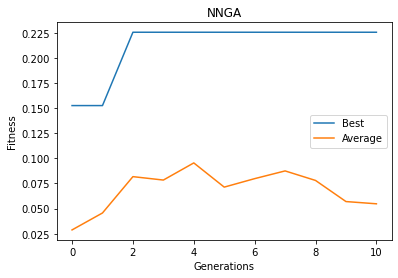

In [19]:
ga.plot_stats("NNGA")

We can look at how the archive grew over time. There will always be at least k behaviors in the archive. Typically, the first k behaviors may not be that interesting because the archive needs to reach this length before novelty can start to be measured. 

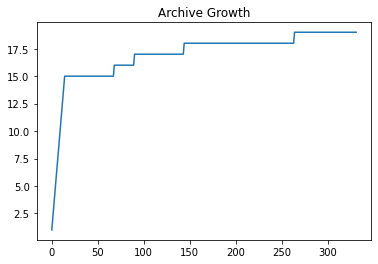

In [20]:
ga.novelty_search.plot_growth()

1 Let's test all of the behaviors in the archive that were added _after_ the first k.

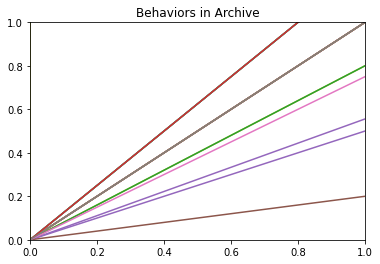

In [21]:
ga.novelty_search.plot_behaviors()

coverage 0.500000


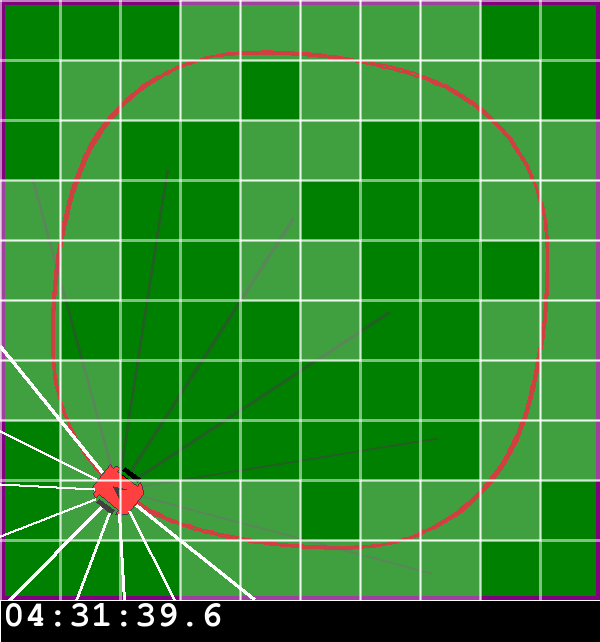

In [22]:
chromo = ga.bestEver
#ga.mutation(chromo)
coverage = ga.test_coverage(chromo, 600)
print("coverage %f" % coverage)
ga.world.get_image()


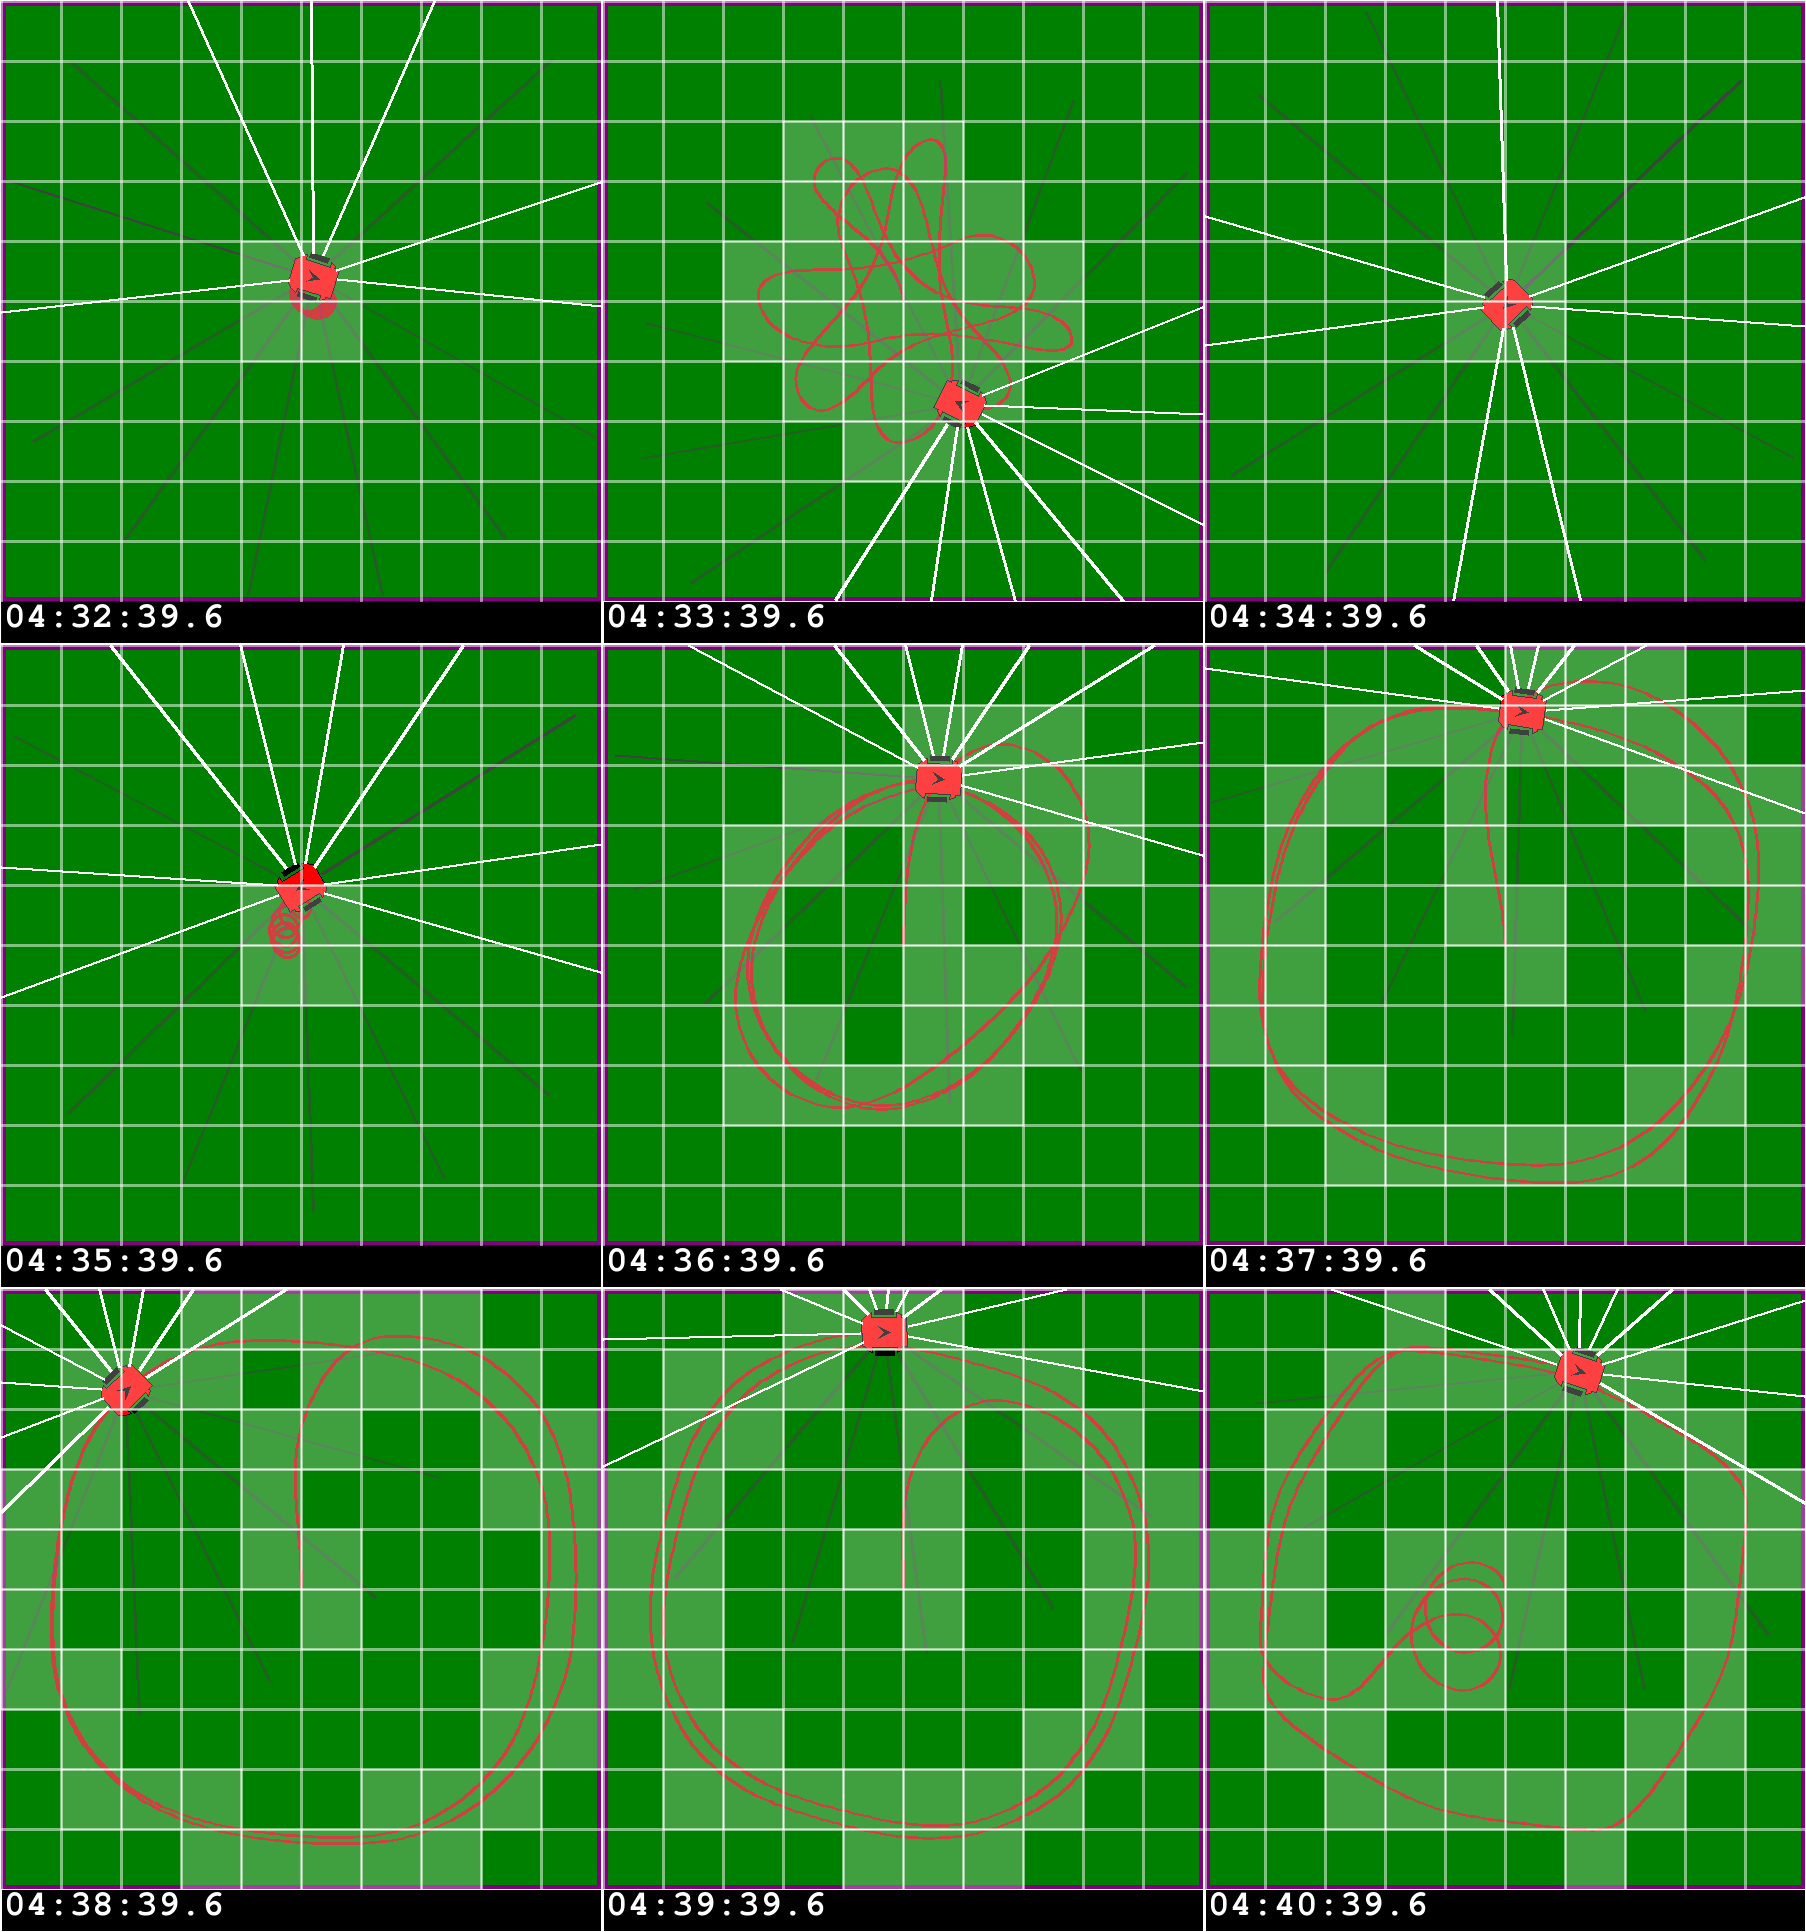

In [23]:
images = []
for i in range(10, len(ga.novelty_search.archive)):
    chromo = ga.novelty_search.archive[i][2]
    coverage = ga.test_coverage(chromo, 60)
    print(f"archive chromo {i} coverage {coverage}")
    images.append(ga.world.get_image())
gallery(images)

Although we were searching broadly for novel behaviors, the GA typically does find many behaviors that do produce reasonably good coverage as well.